In [7]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Packages for quantum stuff
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

In [2]:
# functions \/\/\/\/\/
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


def cost_func_estimator(params, ansatz, estimator):  # Removed hamiltonian argument
    # The Hamiltonian information should ideally be accessed via the ansatz
    # or passed if strictly needed, but Estimator needs the observable.
    # Rebuild observable based on ansatz qubits if needed, or use pre-built one
    # Assuming cost_hamiltonian is defined globally/accessible here for simplicity
    # apply_layout might be needed if the estimator doesn't handle it automatically
    # based on the transpiled ansatz. Let's assume estimator + transpiled ansatz handles layout.
    isa_observable = cost_hamiltonian.apply_layout(
        ansatz.layout
    )  # Apply layout based on *transpiled* ansatz

    pub = (ansatz, isa_observable, [params])  # Pass params in a list for V2 PUB
    job = estimator.run(pubs=[pub])  # Pass pubs as keyword arg

    # Handle potential errors during job execution
    try:
        results = job.result()[0]  # Get the first PubResult
        cost = results.data.evs[0]  # Get the first (and only) EV
    except Exception as e:
        print(f"Error getting result for params {params}: {e}")
        # Return a high cost or handle error appropriately for the optimizer
        return float("inf")

    # Ensure cost is a standard float for scipy.optimize
    cost_float = float(np.real(cost))
    objective_func_vals.append(cost_float)
    print(f"Params: {params}, Cost: {cost_float}")  # Add print for debugging
    return cost_float


Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
Ansatz Parameters: ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])
Starting optimization...
Params: [3.14159265 1.57079633 3.14159265 1.57079633], Cost: -0.08391608391608392
Params: [4.14159265 1.57079633 3.14159265 1.57079633], Cost: 0.03796203796203797
Params: [3.14159265 2.57079633 3.14159265 1.57079633], Cost: -0.04395604395604395
Params: [3.14159265 1.57079633 4.14159265 1.57079633], Cost: -0.013986013986013988
Params: [3.14159265 1.57079633 3.14159265 2.57079633], Cost: 0.13386613386613386
Params: [2.67683665 1.41841731 2.87492937 0.74033068], Cost: 2.0599400599400597
Params: [2.90921465 1.49460682 3.00826101 1.1555635 ], Cost: 1.1488511488511488
Params: [3.39138888 1.56905956 3.13855331 1.56133095], Cost: -0.011988011988011991


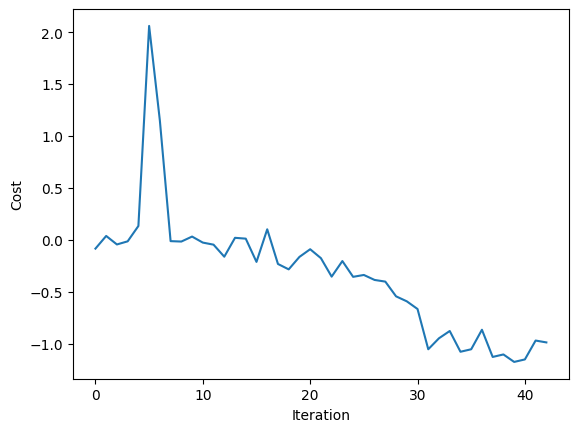

In [11]:
# 1
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
# draw_graph(graph, node_size=600, with_labels=True)


# 2
max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

# 3
# Hopefully we should be able to insert the circuit created using the openQAOA package somewhere here
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all() #measurement not needed for estimator?
print("Ansatz Parameters:", circuit.parameters)
# circuit.draw("mpl")


# 4
fakeBackend = FakeBrisbane()
simulator = AerSimulator.from_backend(fakeBackend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=fakeBackend)
candidate_circuit = pm.run(circuit)
# candidate_circuit.draw("mpl", fold=False, idle_wires=False)

# 5 Setting the parameters for the QAOA cost and mixer hamiltonian
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

# 6 finding the optimal parameters for the QAOA circuit using a 'estimator'
objective_func_vals = []  # Global variable

estimator = Estimator(mode=simulator)
estimator.options.default_shots = 1000

print("Starting optimization...")
result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, estimator),  # Pass transpiled circuit and estimator
    method="COBYLA",
    tol=1e-2,  # Tolerance for termination
    options={"maxiter": 100},  # Set max iterations to prevent running forever
)
print("Optimization Result:")
print(result)

# You can plot the objective function values if desired
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw()

In [15]:
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="e3d76332de187f9b82dbd1904444ae8aaca1b80ed6fa6b8ae43d3b8f2641c0eea75884a158e0208d8d46c6d03551260f840427bfee34f4e323e13454fbf86fdf",
    overwrite=True,
    set_as_default=True,
)


service = QiskitRuntimeService(channel="ibm_quantum")
backend_name = "ibm_brisbane"

try:
    backend = service.backend(backend_name)
    print(f"Successfully retrieved backend: {backend.name}")
    print(f"Number of qubits: {backend.num_qubits}")

except Exception as e:
    print(f"Error retrieving backend '{backend_name}': {e}")
    print(f"- Available backends for your account: {[b.name for b in service.backends()]}")
    backend = None # Set backend to None if retrieval failed

/var/folders/ph/hp043kk921q2v4grp3l2v6nw0000gq/T/ipykernel_45091/2631919159.py:9: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


Successfully retrieved backend: ibm_brisbane
Number of qubits: 127


In [ ]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 1000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
jobID = job.job_id()
print(f"You can monitor the job status at: https://quantum.ibm.com/jobs/{jobID}")

In [22]:
print('This job\'s job ID is:', jobID)
print("Submission script finished.")

This job's job ID is: d09n5qerxz8g008a31m0
Submission script finished.
